In [49]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import (
    EulerSolver,
    plot_1d_slice,
)
from superfv.initial_conditions import decaying_turbulence_1d

In [50]:
sim = EulerSolver(
    ic=partial(decaying_turbulence_1d, seed=1),
    nx=100,
    p=0,
    isothermal=True,
)

In [51]:
sim.run(n=10)

Step #10 @ t=6.02e-03 | dt=9.44e-04 | min(rho)=1.06e-02, min(P)=1.06e-02 | (done)                   


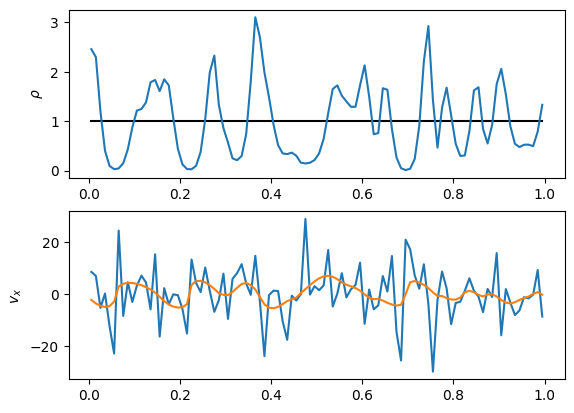

In [52]:
fig, axs = plt.subplots(2, 1)

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")

plot_1d_slice(sim, axs[0], "rho", t=0, color="k")
plot_1d_slice(sim, axs[0], "rho")

plot_1d_slice(sim, axs[1], "vx", t=0)
plot_1d_slice(sim, axs[1], "vx")